In [20]:
"""Definition of a Reservoir structure
"""

###################################################################
#                            Import                               #
###################################################################

import numpy as np
import matplotlib.pyplot as plt
import os

from brian2 import start_scope, Network, NeuronGroup, Synapses,\
SpikeGeneratorGroup, SpikeMonitor, metre, second, volt, mV, ms, us,\
defaultclock, prefs

os.chdir("/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic")

from dynapseReservoir.networks.reservoirsParameters import generalNetP
from dynapseReservoir.networks.reservoirsParameters import r64_1_1_P
import dynapseReservoir.supportFunctions as supp

import DYNAPSETools.dynapseNetGenerator as DNG

# folderName = os.path.dirname(os.path.abspath(__file__))
folderName = "/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic/caer/myoutputs/thesis_output_aedat/thesis_code/"

plt.close("all")



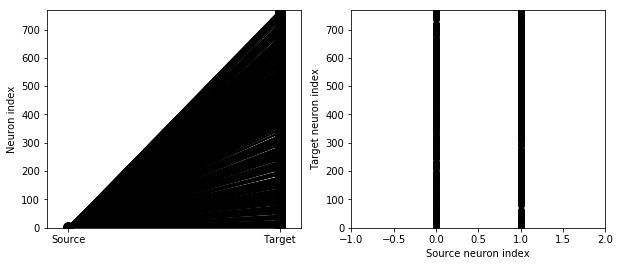

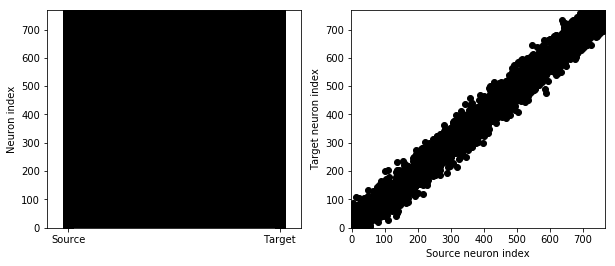

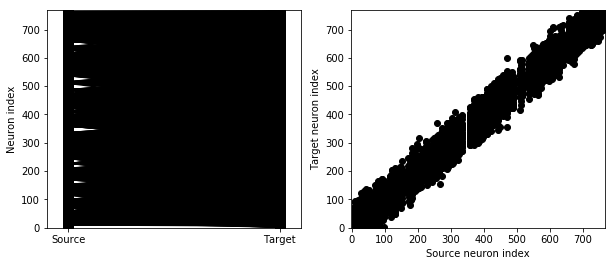

In [17]:
largeResSize = r64_1_1_P["N_Res"] * 3


###################################################################
#                            Simulation                           #
###################################################################

np.random.seed(r64_1_1_P["rand_seed"])

################################## Create Network
start_scope()
Net = Network()

################################## Neuron equation parameters
ke_dist_Res = r64_1_1_P["ke_dist_Res"]
re_dist_Res = r64_1_1_P["re_dist_Res"]
ki_dist_Res = r64_1_1_P["ki_dist_Res"]
ri_dist_Res = r64_1_1_P["ri_dist_Res"]

eqs = '''
        x : 1
        y : 1
'''

################################## Define inputs
gInpGroup = NeuronGroup(r64_1_1_P["N_in"], eqs, name='gInpGroup')

################################## Define Reservoir
Reservoir = NeuronGroup(largeResSize, eqs, name="Reservoir")

# Set positions
positions = np.arange(0, largeResSize)
Reservoir.x = (positions % r64_1_1_P["N_Res_col"]).astype(int)
Reservoir.y = (positions / r64_1_1_P["N_Res_row"]).astype(int)


# Define reservoir topology
randomIdx = np.random.permutation(positions)
numExcNeurons = int(np.round(largeResSize * r64_1_1_P["perc_exc_Res"]))
excitatoryNeurons = np.sort(randomIdx[:numExcNeurons])
inhibitoryNeurons = np.sort(randomIdx[numExcNeurons:])

################################## Define Connections
# Input to Reservoir
gInpGroupToReservoir = Synapses(source = gInpGroup, target = Reservoir, model = "w : 1", name = "gInpGroupToReservoir")
gInpGroupToReservoir.connect(p = r64_1_1_P["p_InRes"])
gInpGroupToReservoir.w = 1 + supp.normalPosValues(mean = r64_1_1_P["we_mu_InRes"],
                                                  sd = r64_1_1_P["we_sigma_InRes"],
                                                  size = len(gInpGroupToReservoir.i))
# Reservoir to Reservoir excitatory
ReservoirExcToReservoir = Synapses(source = Reservoir, target = Reservoir, model = "w : 1", name="ReservoirExcToReservoir")

for neuron in excitatoryNeurons:
    ReservoirExcToReservoir.connect(condition = "i == neuron",
                p = "ke_dist_Res * exp(-((x_pre-x_post)**2 + (y_pre-y_post)**2)/(2*re_dist_Res**2))")
ReservoirExcToReservoir.w = 1 + supp.normalPosValues(mean = r64_1_1_P["we_mu_Res"],
                                                            sd = r64_1_1_P["we_sigma_Res"],
                                                            size = len(ReservoirExcToReservoir.i))
# Reservoir to Reservoir inhibitory
ReservoirInhToReservoir = Synapses(source = Reservoir, target = Reservoir, model = "w : 1", name="ReservoirInhToReservoirExc")
for neuron in inhibitoryNeurons:
    ReservoirInhToReservoir.connect(condition = "i == neuron",
                p = "ki_dist_Res * exp(-((x_pre-x_post)**2 + (y_pre-y_post)**2)/(2*ri_dist_Res**2))")
ReservoirInhToReservoir.w = 1 + supp.normalPosValues(mean = r64_1_1_P["wi_mu_Res"],
                                                               sd = r64_1_1_P["wi_sigma_Res"],
                                                               size = len(ReservoirInhToReservoir.i))
################################## Define Network
Net.add(gInpGroup, Reservoir,
        gInpGroupToReservoir, ReservoirExcToReservoir, ReservoirInhToReservoir)

################################## Connectivity
supp.visualise_connectivity(gInpGroupToReservoir)
supp.visualise_connectivity(ReservoirExcToReservoir)
supp.visualise_connectivity(ReservoirInhToReservoir)

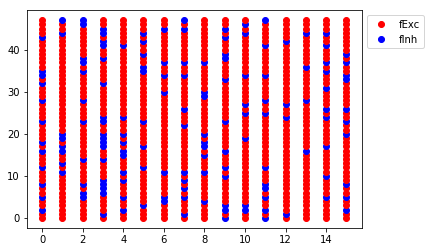

In [21]:

###################################################################
#                            Network                              #
###################################################################

# ====================== Istantiate CONTROL VIRTUAL CHIP populations 
# _InTargetEncoding: First 15 neurons in the Virtual Chip are used for encoding the target corresponding to the input pattern
size = generalNetP["sizeTargetEncoding"]
U, C, N = generalNetP["inTargetEncodingPos"]
_InTargetEncoding = DNG.DevicePopulation(name = "InTargetEncoding", chip_id = U, core_id = C, start_neuron = N, size = size, neuronsType = "fExc")

# _InStartTrigger: neuron used to encode the beginning of the input such to allow output data extractions
U, C, N = generalNetP["inStartTriggerPos"]
_InStartTrigger = DNG.DevicePopulation(name = "InStartTrigger", chip_id = U, core_id = C, neurons_id = N, neuronsType = "fExc")
    
# _InStopTrigger: 
U, C, N = generalNetP["inStopTriggerPos"]
_InStopTrigger = DNG.DevicePopulation(name = "InStopTrigger", chip_id = U, core_id = C, neurons_id = N, neuronsType = "fExc")

U, C, N = generalNetP["inEndStimulusPos"]
_InEndStimulus = DNG.DevicePopulation(name = "InEndStimulus", chip_id = U, core_id = C, neurons_id = N, neuronsType = "fExc")

# ====================== Istantiate CONTROL CHIP populations
# TARGET ENCODING population
size = generalNetP["sizeTargetEncoding"]
U, C, N = generalNetP["targetEncodingPos"]
_TargetEncoding = DNG.DevicePopulation(name = "TargetEncoding", chip_id = U, core_id = C, start_neuron = N, size = size, neuronsType = "fExc")
# EXPERIMENT TRIGGER populations

U, C, N = generalNetP["startTriggerPos"]
_StartTrigger = DNG.DevicePopulation(name = "StartTrigger", chip_id = U, core_id = C, neurons_id = N, neuronsType = "fExc")

U, C, N = generalNetP["stopTriggerPos"]
_StopTrigger = DNG.DevicePopulation(name = "StopTrigger", chip_id = U, core_id = C, neurons_id = N, neuronsType = "fExc")

# END STIMULUS population
U, C, N = generalNetP["endStimulusPos"]
_EndStimulus = DNG.DevicePopulation(name = "EndStimulus", chip_id = U, core_id = C, neurons_id = N, neuronsType = "fExc")

# ====================== Istantiate BRIAN2 Populations
# INPUT NEURON
U, C, N0 = generalNetP["inCH0"]
U, C, N1 = generalNetP["inCH1"]
_gInpGroup = DNG.DevicePopulation(neuronsObj = gInpGroup, chip_id = U, core_id = C, neurons_id = [N0, N1], neuronsType = "fExc")

# RESERVOIR
size = largeResSize
U, C, N = generalNetP["reservoirStartPos"]
_Reservoir = DNG.DevicePopulation(neuronsObj = Reservoir, chip_id = U, core_id = C, size = size, neuronsType = "fExc")
_Reservoir[excitatoryNeurons]["neuronsType"] = "fExc"
_Reservoir[inhibitoryNeurons]["neuronsType"] = "fInh"

# ====================== Print Population Distribution separation
supp.topologyMap(_Reservoir)
#    for y in range(0, 10):
    
# ====================== Istantiate CONTROL CONNECTIONS
N = generalNetP["sizeTargetEncoding"]
W = generalNetP["wTargetEncoding"]
_InTargetEncodingToTargetEncoding = DNG.DeviceConnections(sourcePop = _InTargetEncoding, targetPop = _TargetEncoding,
                                                             i = np.arange(0, N), j = np.arange(0, N), w = W * np.ones(N))
W = generalNetP["wInStartTrigger"]
_InStartTriggerToStartTrigger = DNG.DeviceConnections(sourcePop = _InStartTrigger, targetPop = _StartTrigger,
                                                         i = 0, j = 0, w = W)
W = generalNetP["wInStopTrigger"]
_InStopTriggerToStopTrigger = DNG.DeviceConnections(sourcePop = _InStopTrigger, targetPop = _StopTrigger,
                                                         i = 0, j = 0, w = W)
W = generalNetP["wInEndStimulus"]
_InEndStimulusToEndStimulus = DNG.DeviceConnections(sourcePop = _InEndStimulus, targetPop = _EndStimulus,
                                                         i = 0, j = 0, w = W)

# BRIAN2 CONNECTIONS
_gInpGroupToReservoir = DNG.DeviceConnections(sourcePop = _gInpGroup, targetPop = _Reservoir, synapsesObj = gInpGroupToReservoir)
_ReservoirExcToReservoir = DNG.DeviceConnections(sourcePop = _Reservoir, targetPop = _Reservoir, synapsesObj = ReservoirExcToReservoir)
_ReservoirInhToReservoir = DNG.DeviceConnections(sourcePop = _Reservoir, targetPop = _Reservoir, synapsesObj = ReservoirInhToReservoir)


# ====================== Create final Network
allConnections = (_InTargetEncodingToTargetEncoding,
                  _InStartTriggerToStartTrigger,
                  _InStopTriggerToStopTrigger,
                  _InEndStimulusToEndStimulus,
                  _gInpGroupToReservoir,
                  _ReservoirExcToReservoir,
                  _ReservoirInhToReservoir)

# ====================== Write connections to output file in cAER folder
#fileName = "/home/roberto/Desktop/caer/myNetworks/reservoir_r64_1_1.txt"
# fileName = "/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic/caer/mynetworks"
# fileName = folderName
# DNG.write_connections(*allConnections, fileName = fileName)

# ====================== Write connections to output file in current folder
fileName = os.path.join(folderName, 'defaul3core_res.txt')
DNG.write_connections(*allConnections, fileName = fileName)